<font style="font-size:28px;" align="left"><b> Problem Statement 1: </b></font>
<font style="font-size:28px;" align="left"><b> Quantum Circuit Implementing Shor's Algortihm </b></font><br>

In [1]:
import math
import numpy as np
from fractions import Fraction
from math import gcd
import random

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram

In [4]:
def int_to_bitlist(x, n):
    #Return little-endian bitlist of length n representing integer x.
    return [(x >> i) & 1 for i in range(n)]

def bitlist_to_int(bits):
    #Convert little-endian bitlist to int.
    return sum([bit << i for i, bit in enumerate(bits)])

In [6]:
def qft_dagger(qc, qubits):
    #Apply inverse QFT on the provided qubit list (little-endian)
    n = len(qubits)
    for j in range(n//2):
        qc.swap(qubits[j], qubits[n-j-1])
    for j in range(n):
        qc.h(qubits[j])
        for k in range(1, n-j):
            angle = -np.pi / (2**k)
            qc.cp(angle, qubits[j+k], qubits[j])
            
def qft(qc, qubits):
    #Apply QFT (little-endian) on the provided qubit list.
    n = len(qubits)
    for j in range(n):
        qc.h(qubits[j])
        for k in range(1, n-j):
            angle = np.pi / (2**k)
            qc.cp(angle, qubits[j+k], qubits[j])
    for j in range(n//2):
        qc.swap(qubits[j], qubits[n-j-1])

In [7]:
def build_mod_mul_unitary(a, N, n):
    #Build the unitary matrix (2^n x 2^n) that maps |y> -> |a*y mod N> for 0 <= y < N
    #For y >= N (padding states) we map them to themselves to keep unitary.
    
    dim = 2**n
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        if y < N:
            mapped = (a * y) % N
            U[mapped, y] = 1.0
        else:
            # leave padding states unchanged
            U[y, y] = 1.0
    return U

In [8]:
def continued_fraction(x, q_max):
    #Return fraction numerator/denominator approximating x using continued fractions with max denominator q_max
    frac = Fraction(x).limit_denominator(q_max)
    return frac.numerator, frac.denominator

def find_order_from_phase(s, t, a, N, max_den=2**20):
    #Given measured integer s from phase estimation with t counting qubits, estimate r as denominator
    #of fraction closest to s/2^t using continued fractions, then verify a^r mod N == 1.
    
    frac = Fraction(s, 2**t)
    # limit denominator to reasonable size
    k, r = frac.limit_denominator(max_den).numerator, frac.limit_denominator(max_den).denominator
    # try multiples of r to find smallest r such that a^r % N == 1
    for cr in range(1, r+1):
        if r % cr == 0:
            if pow(a, cr, N) == 1:
                return cr
    # fallback: test up to r*2
    for cr in range(r+1, r*2 + 1):
        if pow(a, cr, N) == 1:
            return cr
    return None

In [10]:
def shors_algorithm(N, max_attempts=8, verbose=True):
    if N % 2 == 0:
        return 2, N//2

    attempts = 0
    while attempts < max_attempts:
        attempts += 1
        # pick random 'a' in [2, N-1]
        a = random.randrange(2, N)
        if gcd(a, N) != 1:
            # found non-trivial factor by chance
            g = gcd(a, N)
            if verbose:
                print(f"Attempt {attempts}: got gcd(a, N) = {g} directly (a={a})")
            return g, N // g
        # number of qubits for function register (n) and counting register (t)
        n = math.ceil(math.log2(N))
        t = 2 * n  # number of counting qubits; often chosen as 2n

        if verbose:
            print(f"Attempt {attempts}: trying a = {a}, n = {n}, t = {t}")

        # Build modular multiplication unitary for multiplication by 'a' mod N on n qubits
        U = build_mod_mul_unitary(a, N, n)
        # Check unitarity (should be permutation so unitary)
        assert np.allclose(U.conj().T @ U, np.eye(2**n)), "U not unitary!"

        # Create controlled-U^(2^j) gates by using matrix powers of U
        # precompute U^(2^j) for j in [0, t-1]
        U_powers = []
        for j in range(t):
            power = pow(a, 2**j, N)  # the effective multiplier modulo N for that power
            Up = build_mod_mul_unitary(power, N, n)
            U_powers.append(Up)

        # Now build the QPE circuit: t counting qubits + n function qubits
        qc = QuantumCircuit(t + n, t)

        # Initialize function register to |1> (or |a^0 mod N>)
        # Represent '1' in computational basis
        for i, bit in enumerate(int_to_bitlist(1, n)):
            if bit == 1:
                qc.x(t + i)

        # Put counting register into uniform superposition
        for i in range(t):
            qc.h(i)

        # Apply controlled-U^{2^j} where control is counting qubit i
        for j in range(t):
            # controlled unitary built from U_powers[j]
            Up = U_powers[j]
            gate = UnitaryGate(Up)
            # make controlled gate with 1 control (control qubit in position j)
            # Qiskit's controlled gate can be made using .control()
            cgate = gate.control(1)
            # We need to put the control qubit as qubit j and target as function register qubits [t..t+n-1]
            qc.append(cgate, [j] + list(range(t, t + n)))

        # Apply inverse QFT on counting register
        qft_dagger(qc, range(t))

        # Measure counting register
        qc.measure(range(t), range(t))

        display(qc.draw(output="mpl"))

        
        # Simulate
        simulator = AerSimulator()
        tqc = transpile(qc, simulator, basis_gates=simulator.configuration().basis_gates, optimization_level=1)
        job = simulator.run(tqc,shots=1024)
        result = job.result()
        counts = result.get_counts(qc)

        if verbose:
            print("Raw measurement counts (top 10):", dict(list(counts.items())[:10]))

        # pick the most frequent measured value
        measured_binary = max(counts, key=counts.get)
        s = int(measured_binary, 2)  # measured integer
        if verbose:
            print(f"Measured s = {s} (binary {measured_binary})")

        # classical post-processing: estimate r from s/2^t via continued fractions
        frac = Fraction(s, 2**t)
        approx = frac.limit_denominator(N)  # limit denom to N
        r_candidate = approx.denominator

        # Validate possible r candidates (try small multiples as well)
        r = None
        for k in range(1, 6):  # try small multiples
            candidate = r_candidate * k
            if candidate == 0:r
        qft_dagger(qc, range(t))

        # Measure counting register
        qc.measure(range(t), range(t))

        display(qc.draw(output="mpl"))
        # Simulate
        simulator = AerSimulator()
        tqc = transpile(qc, simulator, basis_gates=simulator.configuration().basis_gates, optimization_level=1)
        job = simulator.run(tqc,shots=1024)
        result = job.result()
        counts = result.get_counts(qc)

        if verbose:
            print("Raw measurement counts (top 10):", dict(list(counts.items())[:10]))

        # pick the most frequent measured value
        measured_binary = max(counts, key=counts.get)
        s = int(measured_binary, 2)  # measured integer
        if verbose:
            print(f"Measured s = {s} (binary {measured_binary})")

        # classical post-processing: estimate r from s/2^t via continued fractions
        frac = Fraction(s, 2**t)
        approx = frac.limit_denominator(N)  # limit denom to N
        r_candidate = approx.denominator

        # Validate possible r candidates (try small multiples as well)
        r = None
        for k in range(1, 6):  # try small multiples
            candidate = r_candidate * k
            if candidate == 0:
                continue
            if pow(a, candidate, N) == 1:
                r = candidate
                break

        if r is None:
            # trying denominators from 1..N
            for d in range(1, N):
                if pow(a, d, N) == 1:
                    r = d
                    break

        if r is None:
            if verbose:
                print("Failed to determine order r from measurement; retrying with new a...")
            continue

        if verbose:
            print(f"Found order r = {r} for a = {a}")

        if r % 2 != 0:
            if verbose:
                print("r is odd, need even r; retrying...")
            continue

        x = pow(a, r // 2, N)  # compute potential factors
        factor1 = gcd(x - 1, N)
        factor2 = gcd(x + 1, N)

        if factor1 in (1, N) or factor2 in (1, N):
            if verbose:
                print("Trivial factors found; retrying...")
            continue

        if verbose:
            print(f"Non-trivial factors found: {factor1}, {factor2}")# success
        return factor1, factor2

    if verbose:
        print("Failed to factor N after max attempts.")
    return None

Attempting to factor N = 9 using Shor's algorithm (simulation).
Attempt 1: trying a = 2, n = 4, t = 8


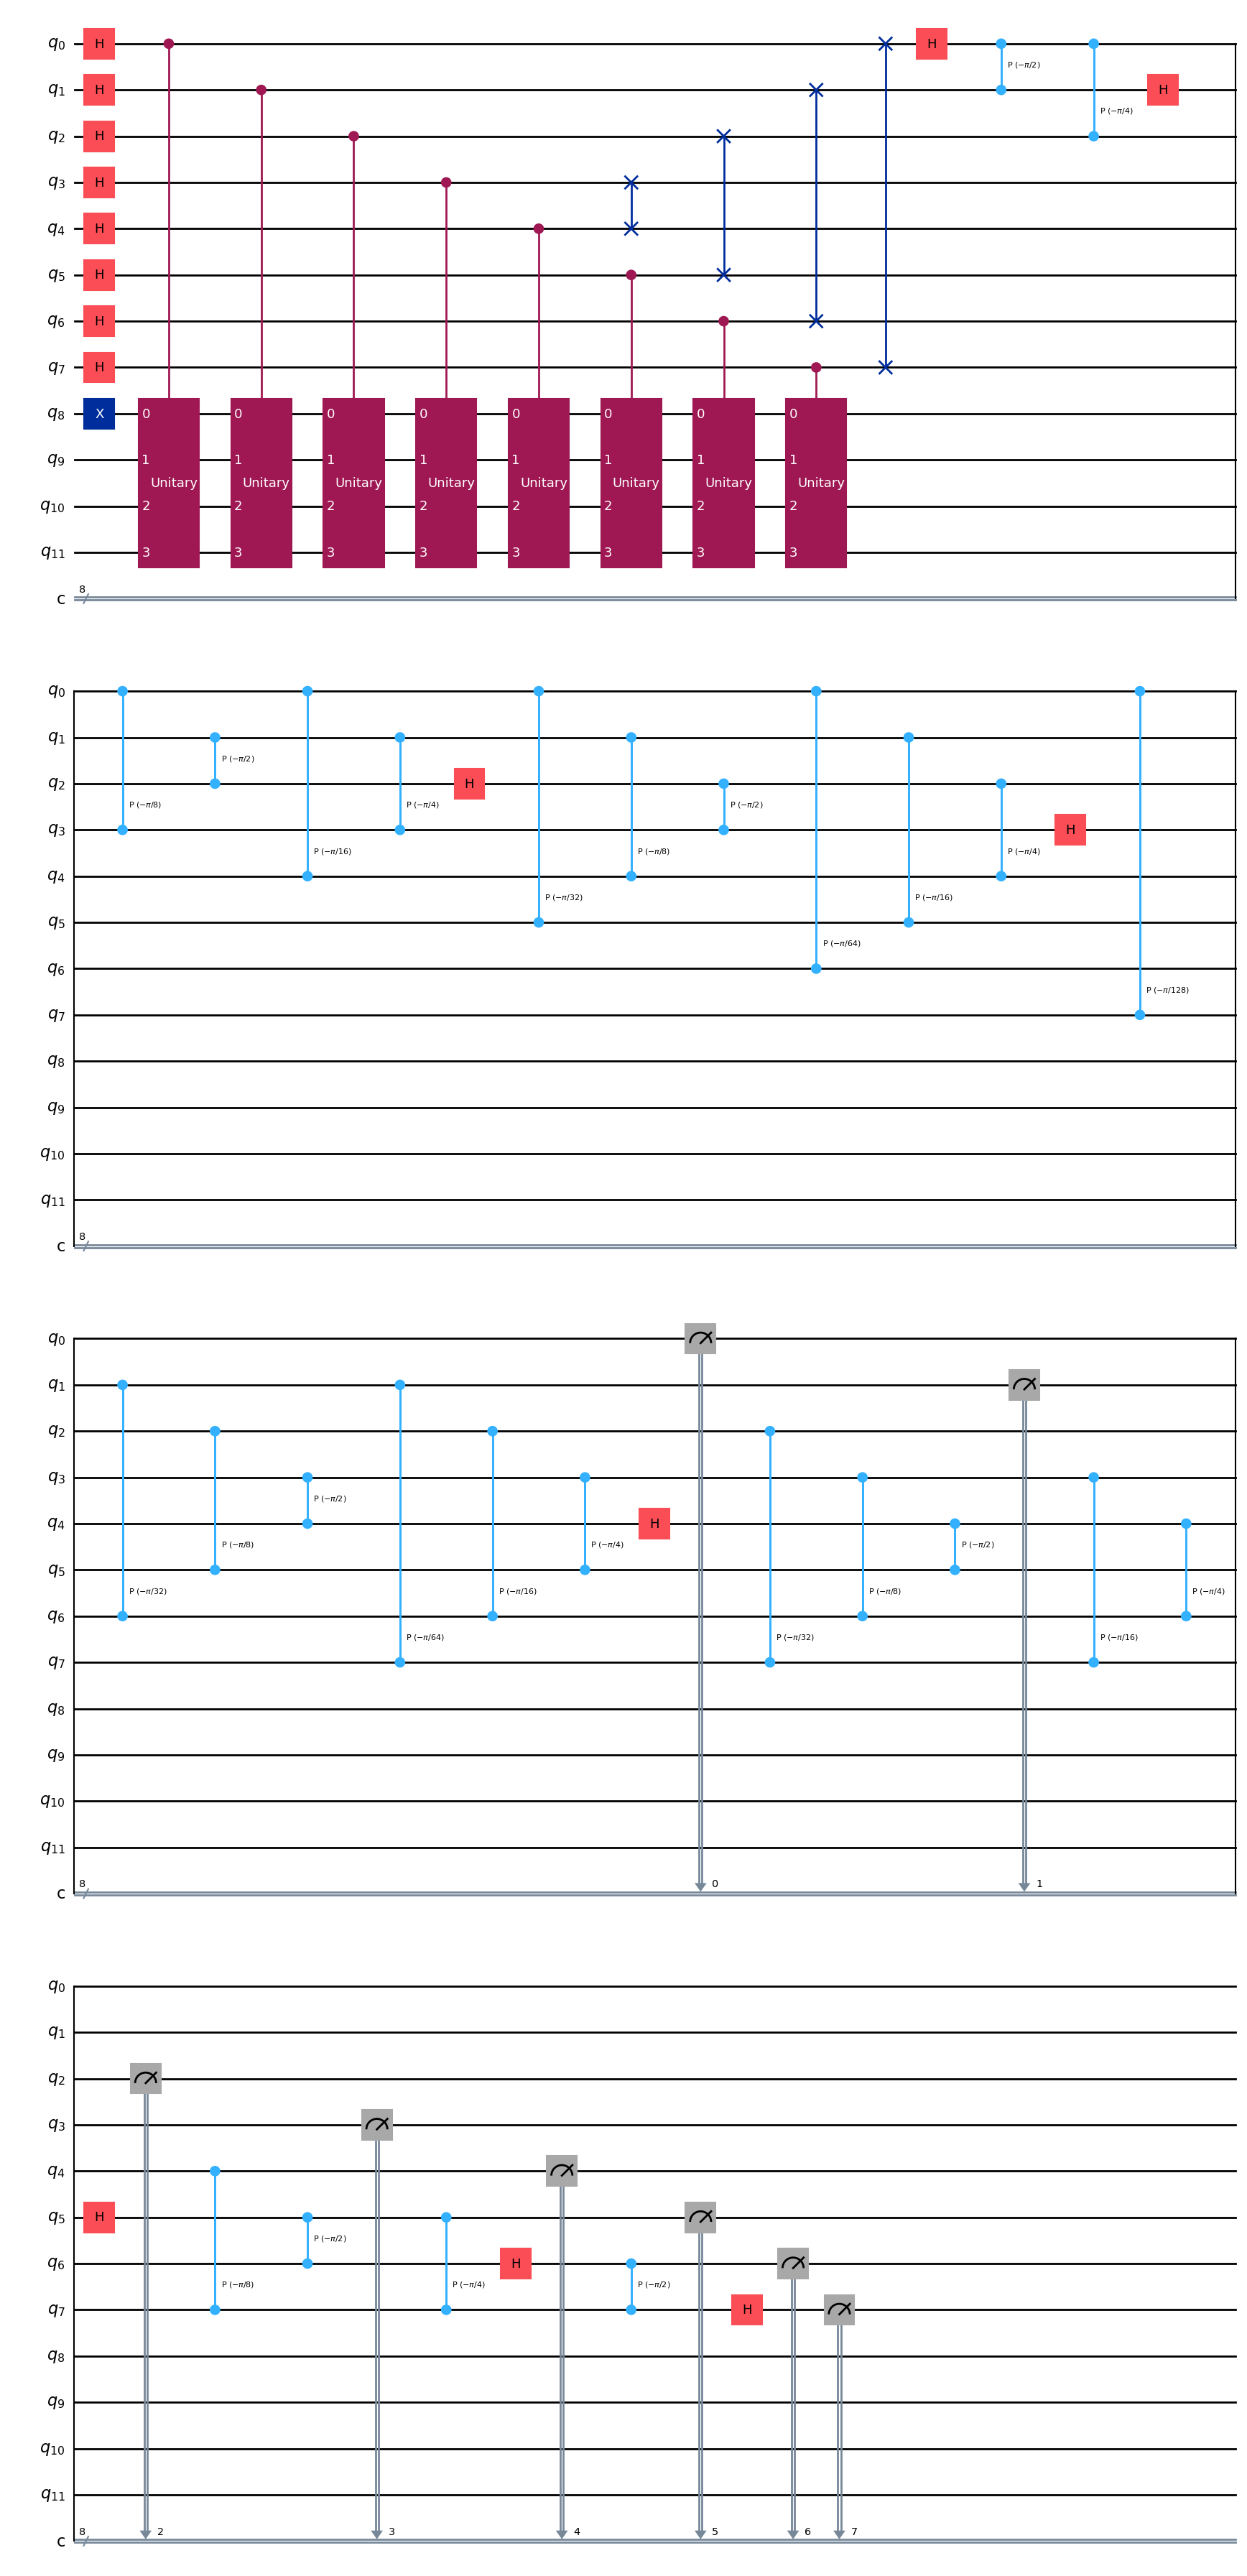

C:\Users\HRITIK DASH\AppData\Roaming\Python\Python313\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


Raw measurement counts (top 10): {'01111001': 1, '10101100': 3, '00101011': 115, '10000000': 150, '11010110': 36, '01010101': 131, '10101001': 8, '00000000': 177, '01010100': 12, '10101011': 118}
Measured s = 0 (binary 00000000)


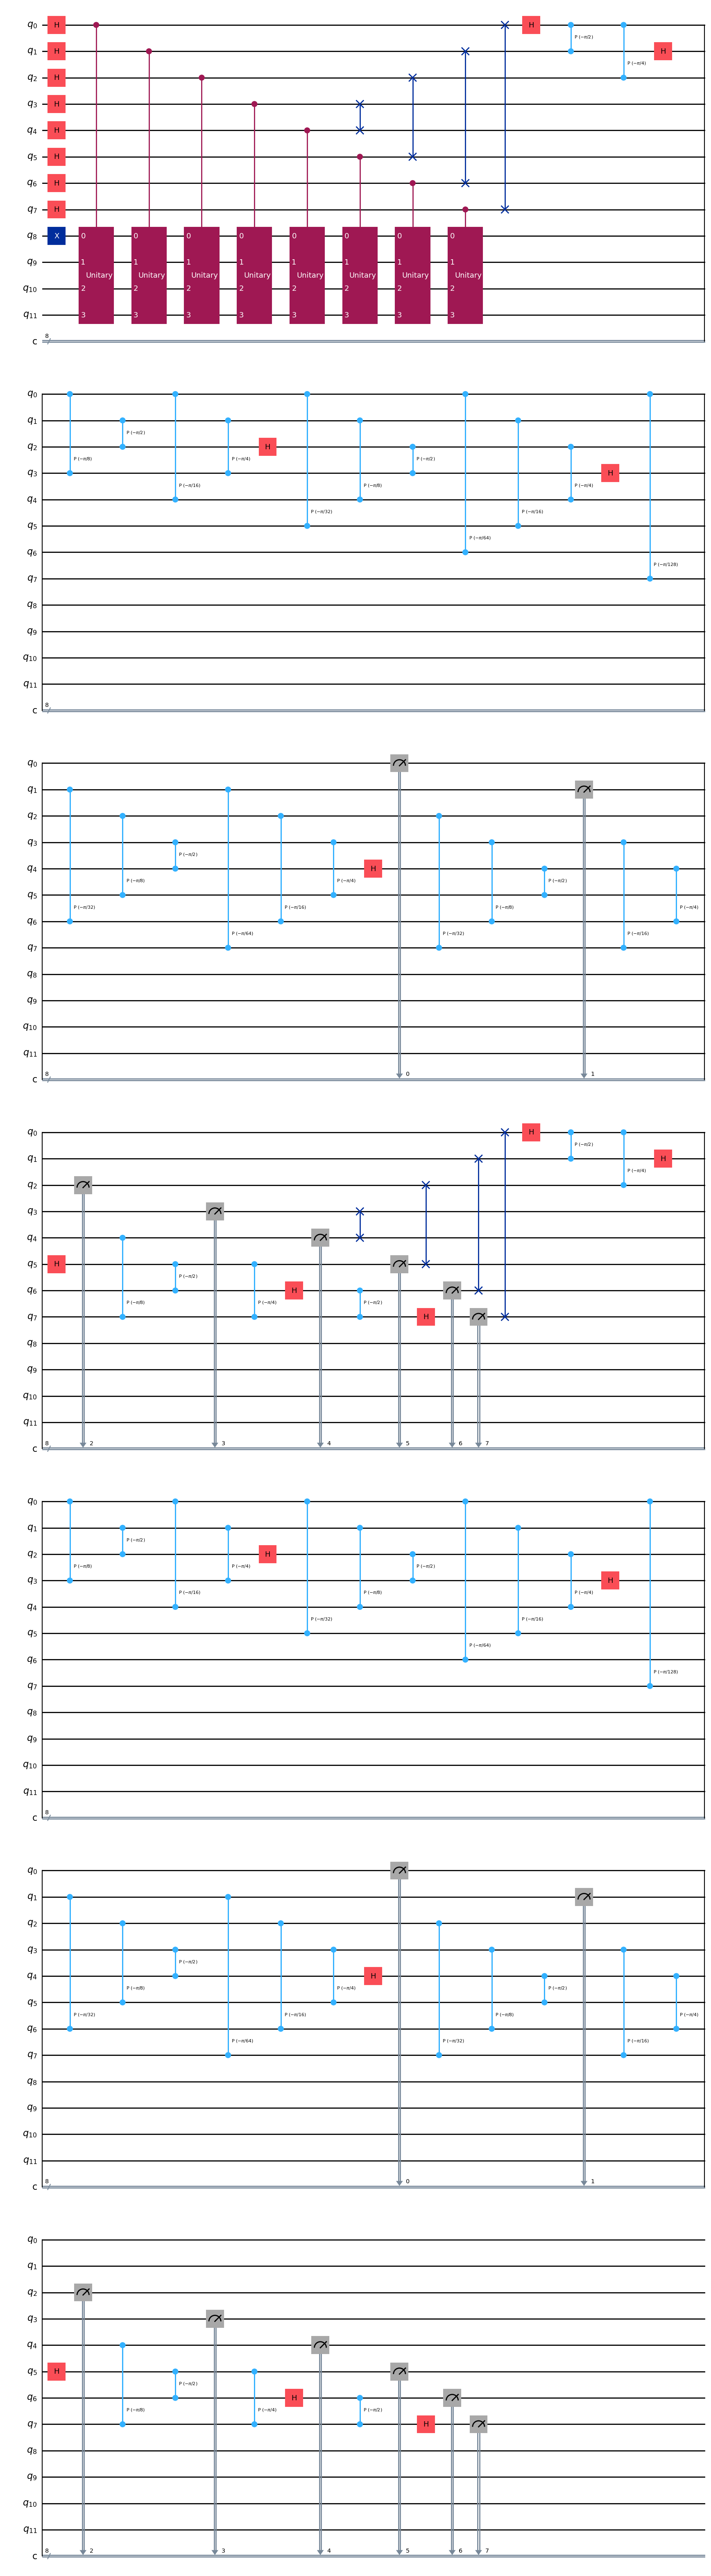

Raw measurement counts (top 10): {'11111000': 2, '10110100': 6, '01011010': 2, '11100111': 6, '11001110': 4, '00101011': 9, '00110101': 4, '01111010': 4, '01000100': 7, '00001010': 6}
Measured s = 142 (binary 10001110)
Found order r = 18 for a = 2
Trivial factors found; retrying...
Attempt 2: trying a = 4, n = 4, t = 8


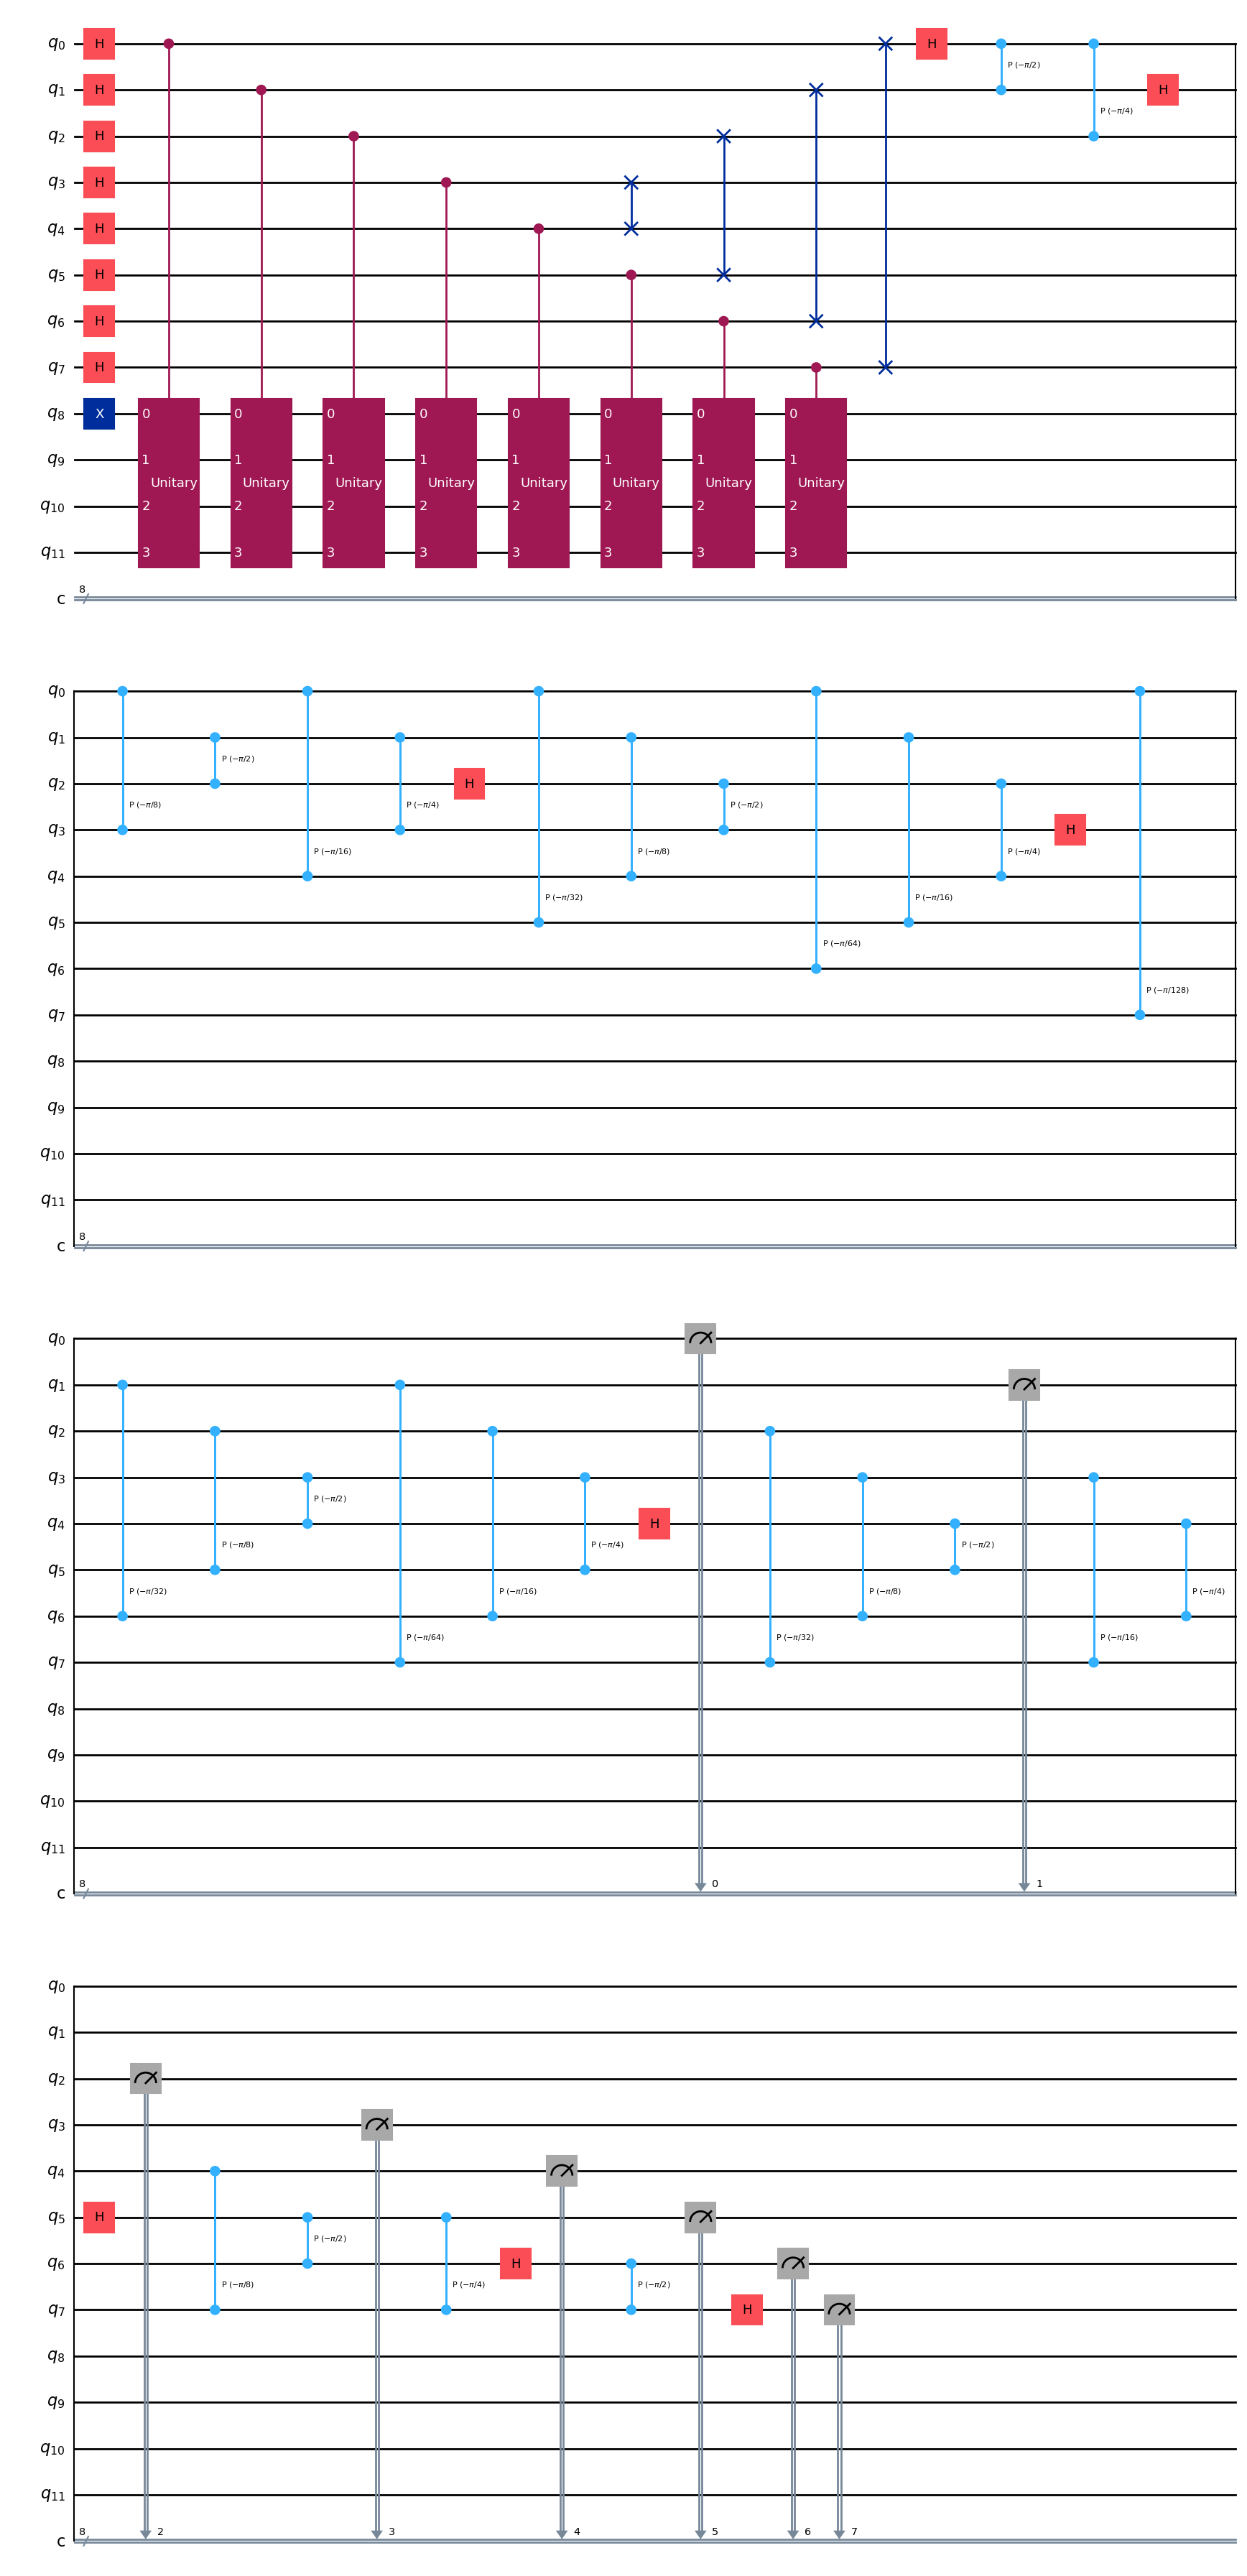

Raw measurement counts (top 10): {'01000110': 1, '00000000': 336, '10101001': 10, '10101010': 66, '01010101': 240, '01010110': 46, '10101011': 244, '01111010': 1, '10101110': 2, '10110100': 2}
Measured s = 0 (binary 00000000)


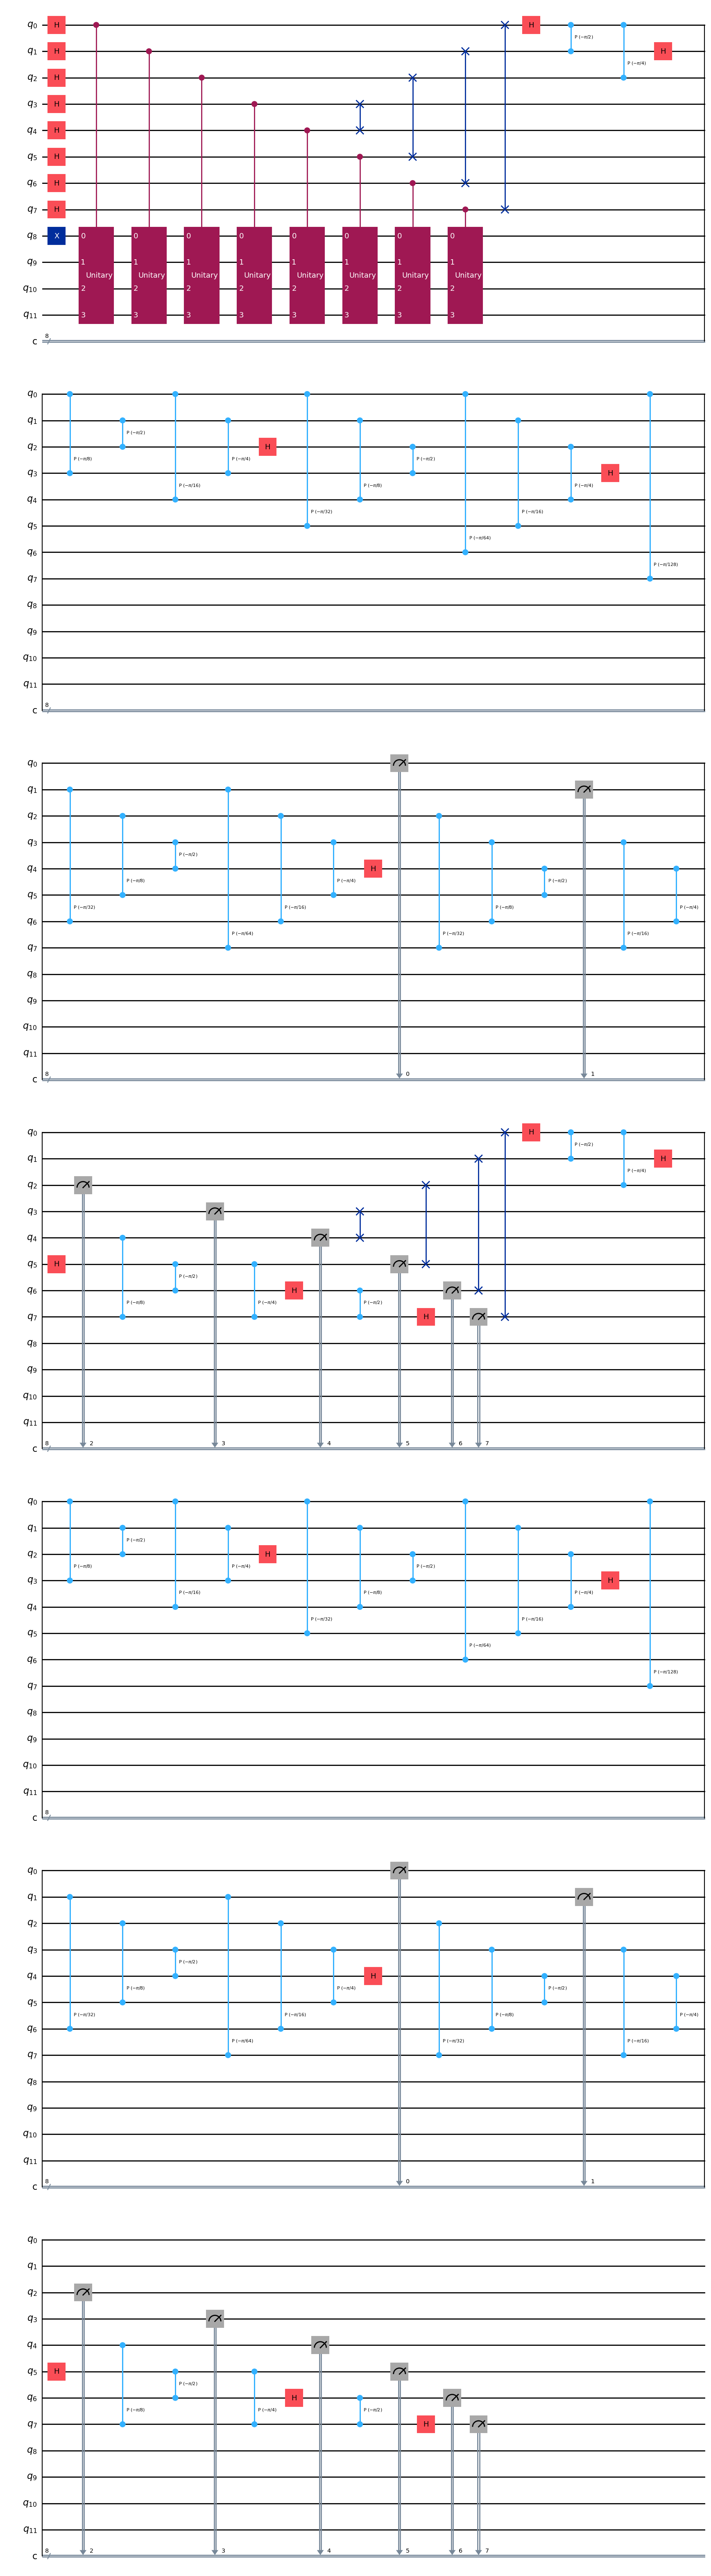

Raw measurement counts (top 10): {'00010100': 7, '01101010': 6, '00101110': 3, '00110010': 4, '11011100': 7, '11100000': 3, '11001011': 5, '01000011': 2, '01111111': 6, '11110000': 2}
Measured s = 94 (binary 01011110)
Found order r = 24 for a = 4
Trivial factors found; retrying...
Attempt 3: trying a = 8, n = 4, t = 8


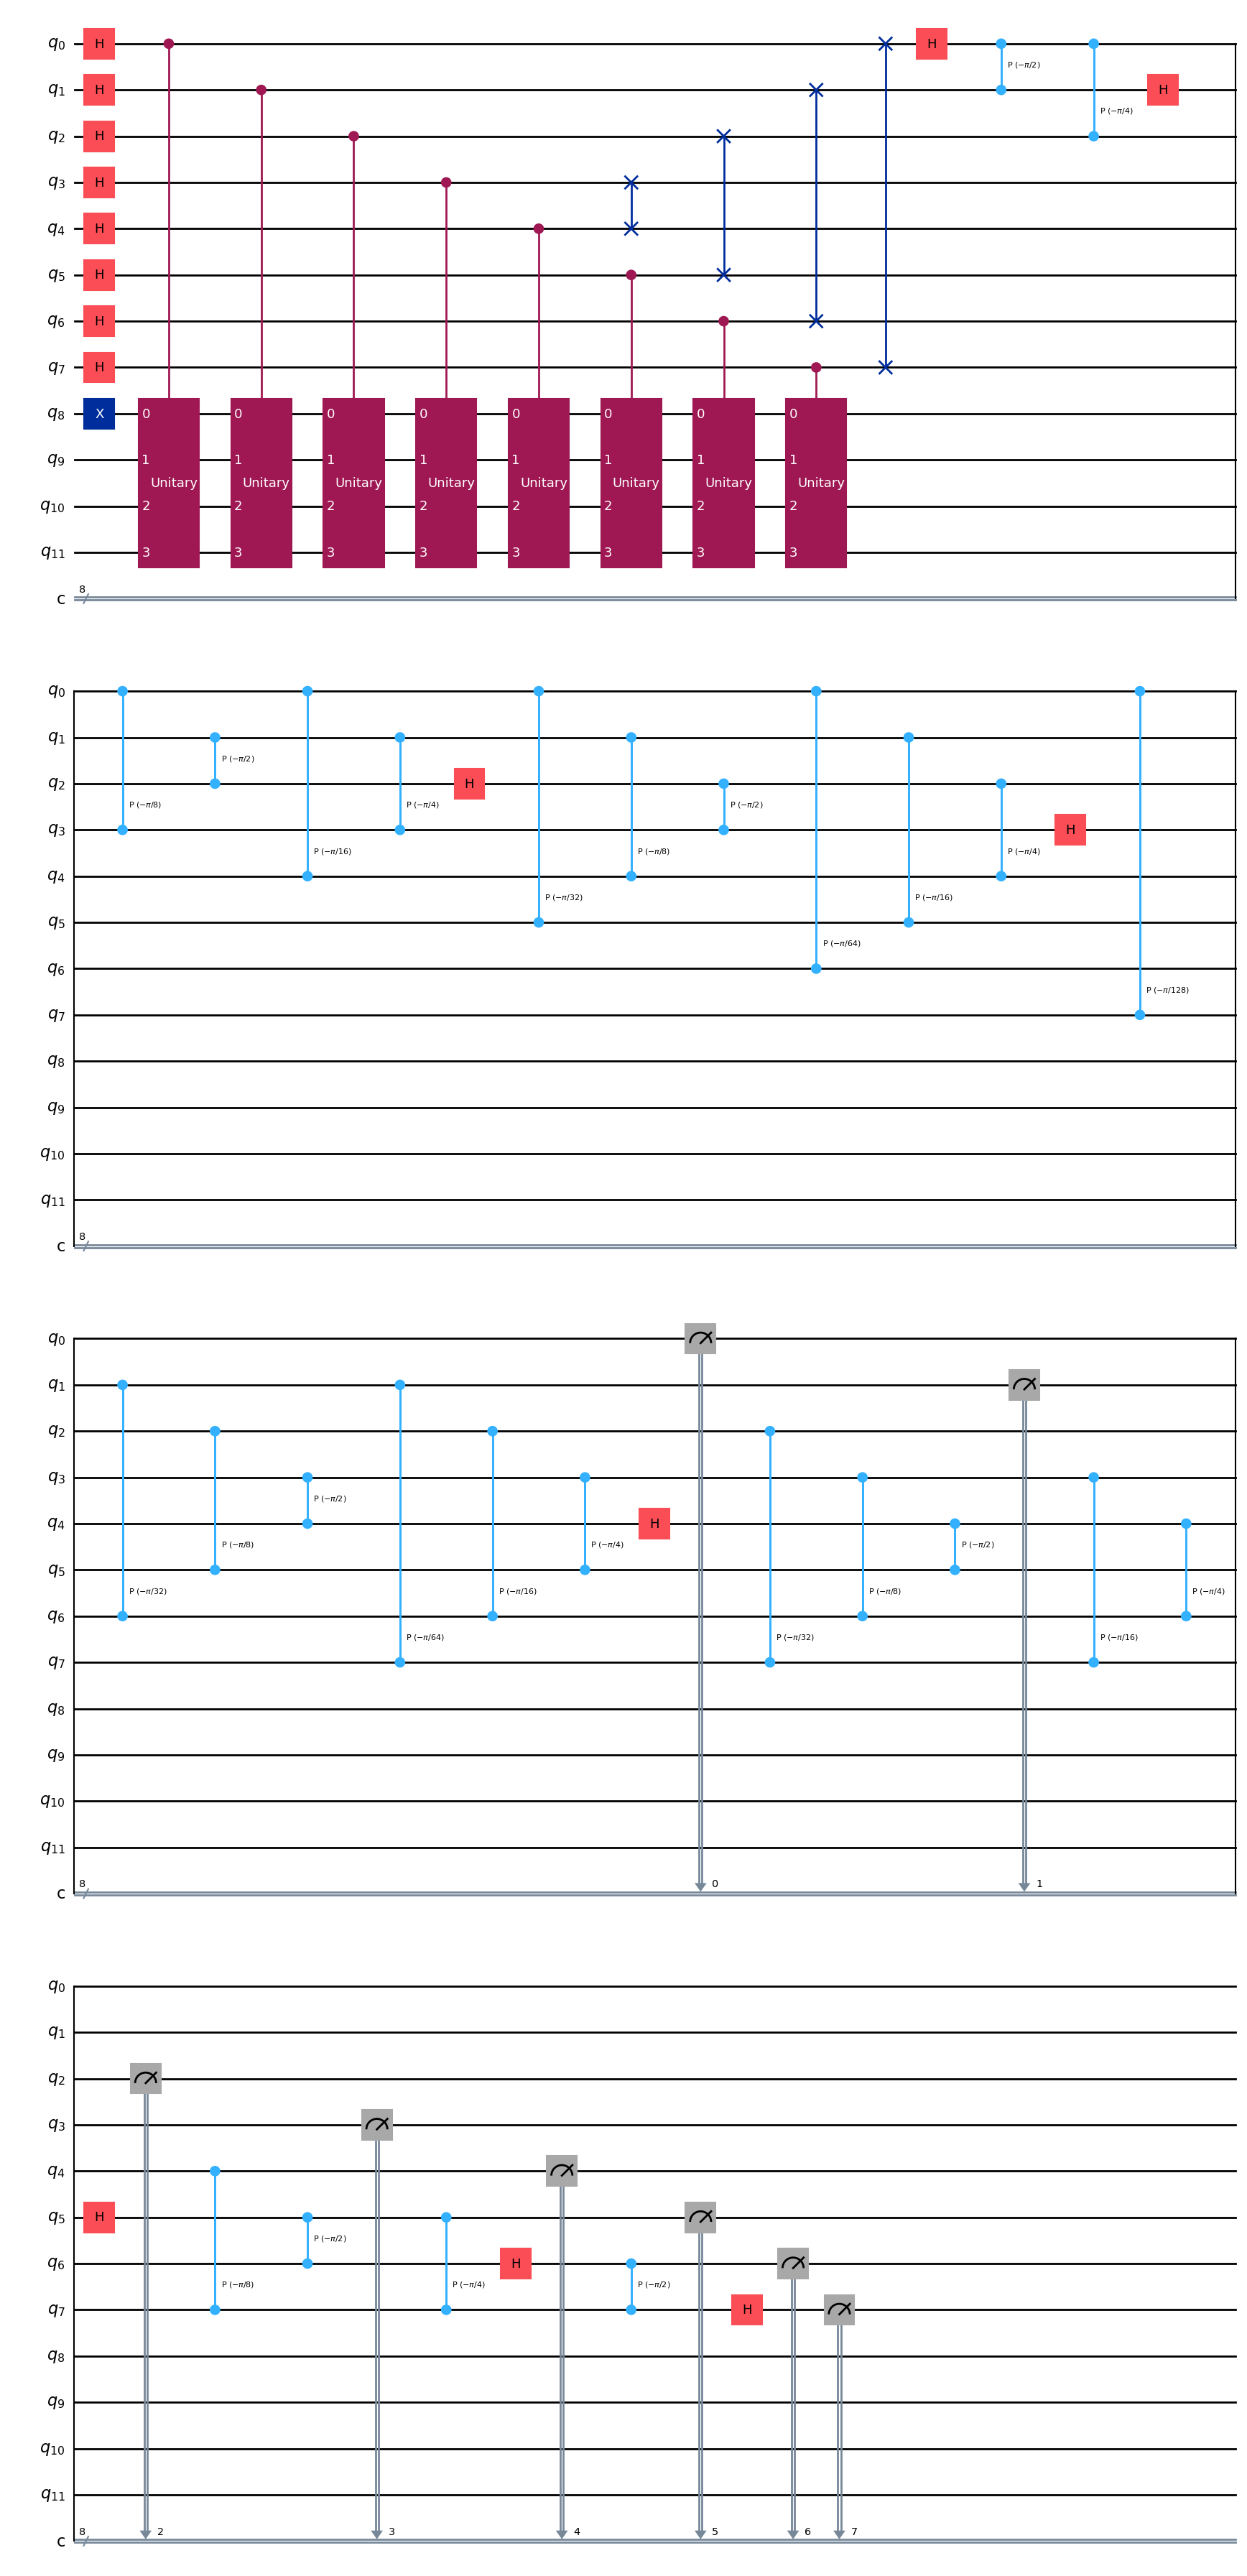

Raw measurement counts (top 10): {'00000000': 515, '10000000': 509}
Measured s = 0 (binary 00000000)


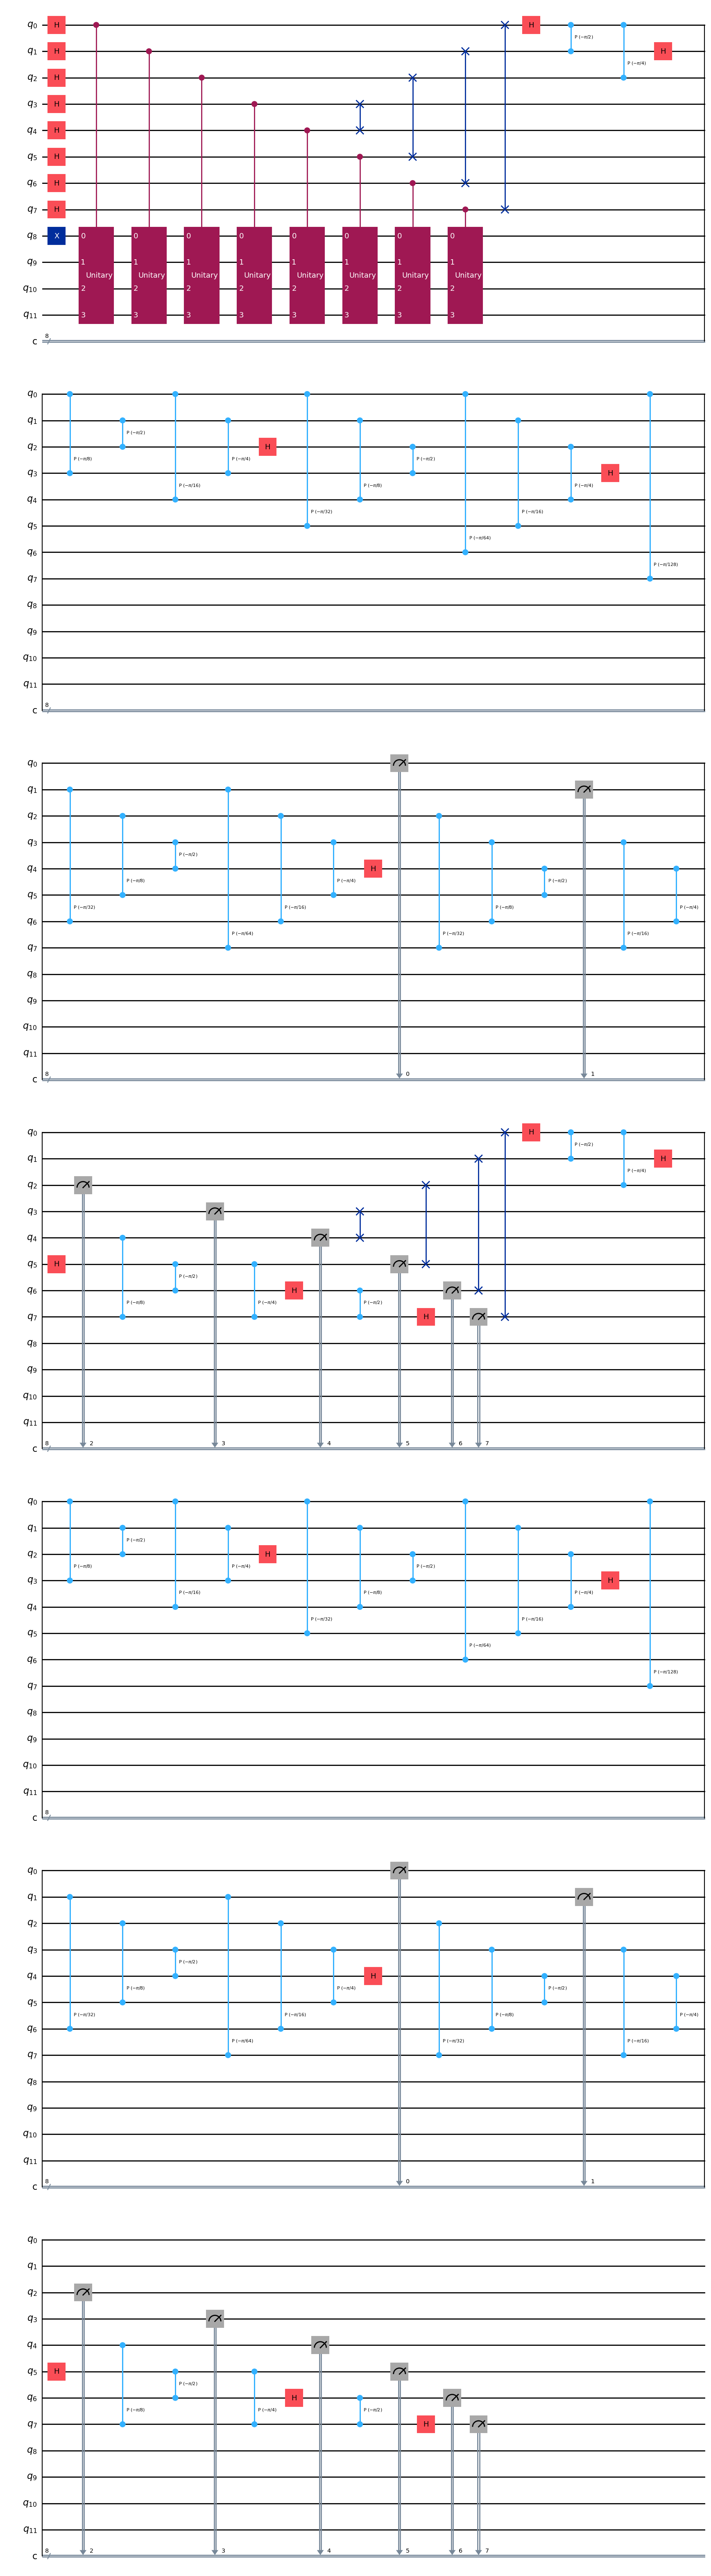

Raw measurement counts (top 10): {'11010110': 4, '01001111': 1, '01110011': 3, '11101110': 4, '11000111': 6, '10100001': 8, '00001000': 4, '11011000': 2, '00011000': 4, '01111011': 2}
Measured s = 23 (binary 00010111)
Found order r = 18 for a = 8
Trivial factors found; retrying...
Attempt 4: trying a = 4, n = 4, t = 8


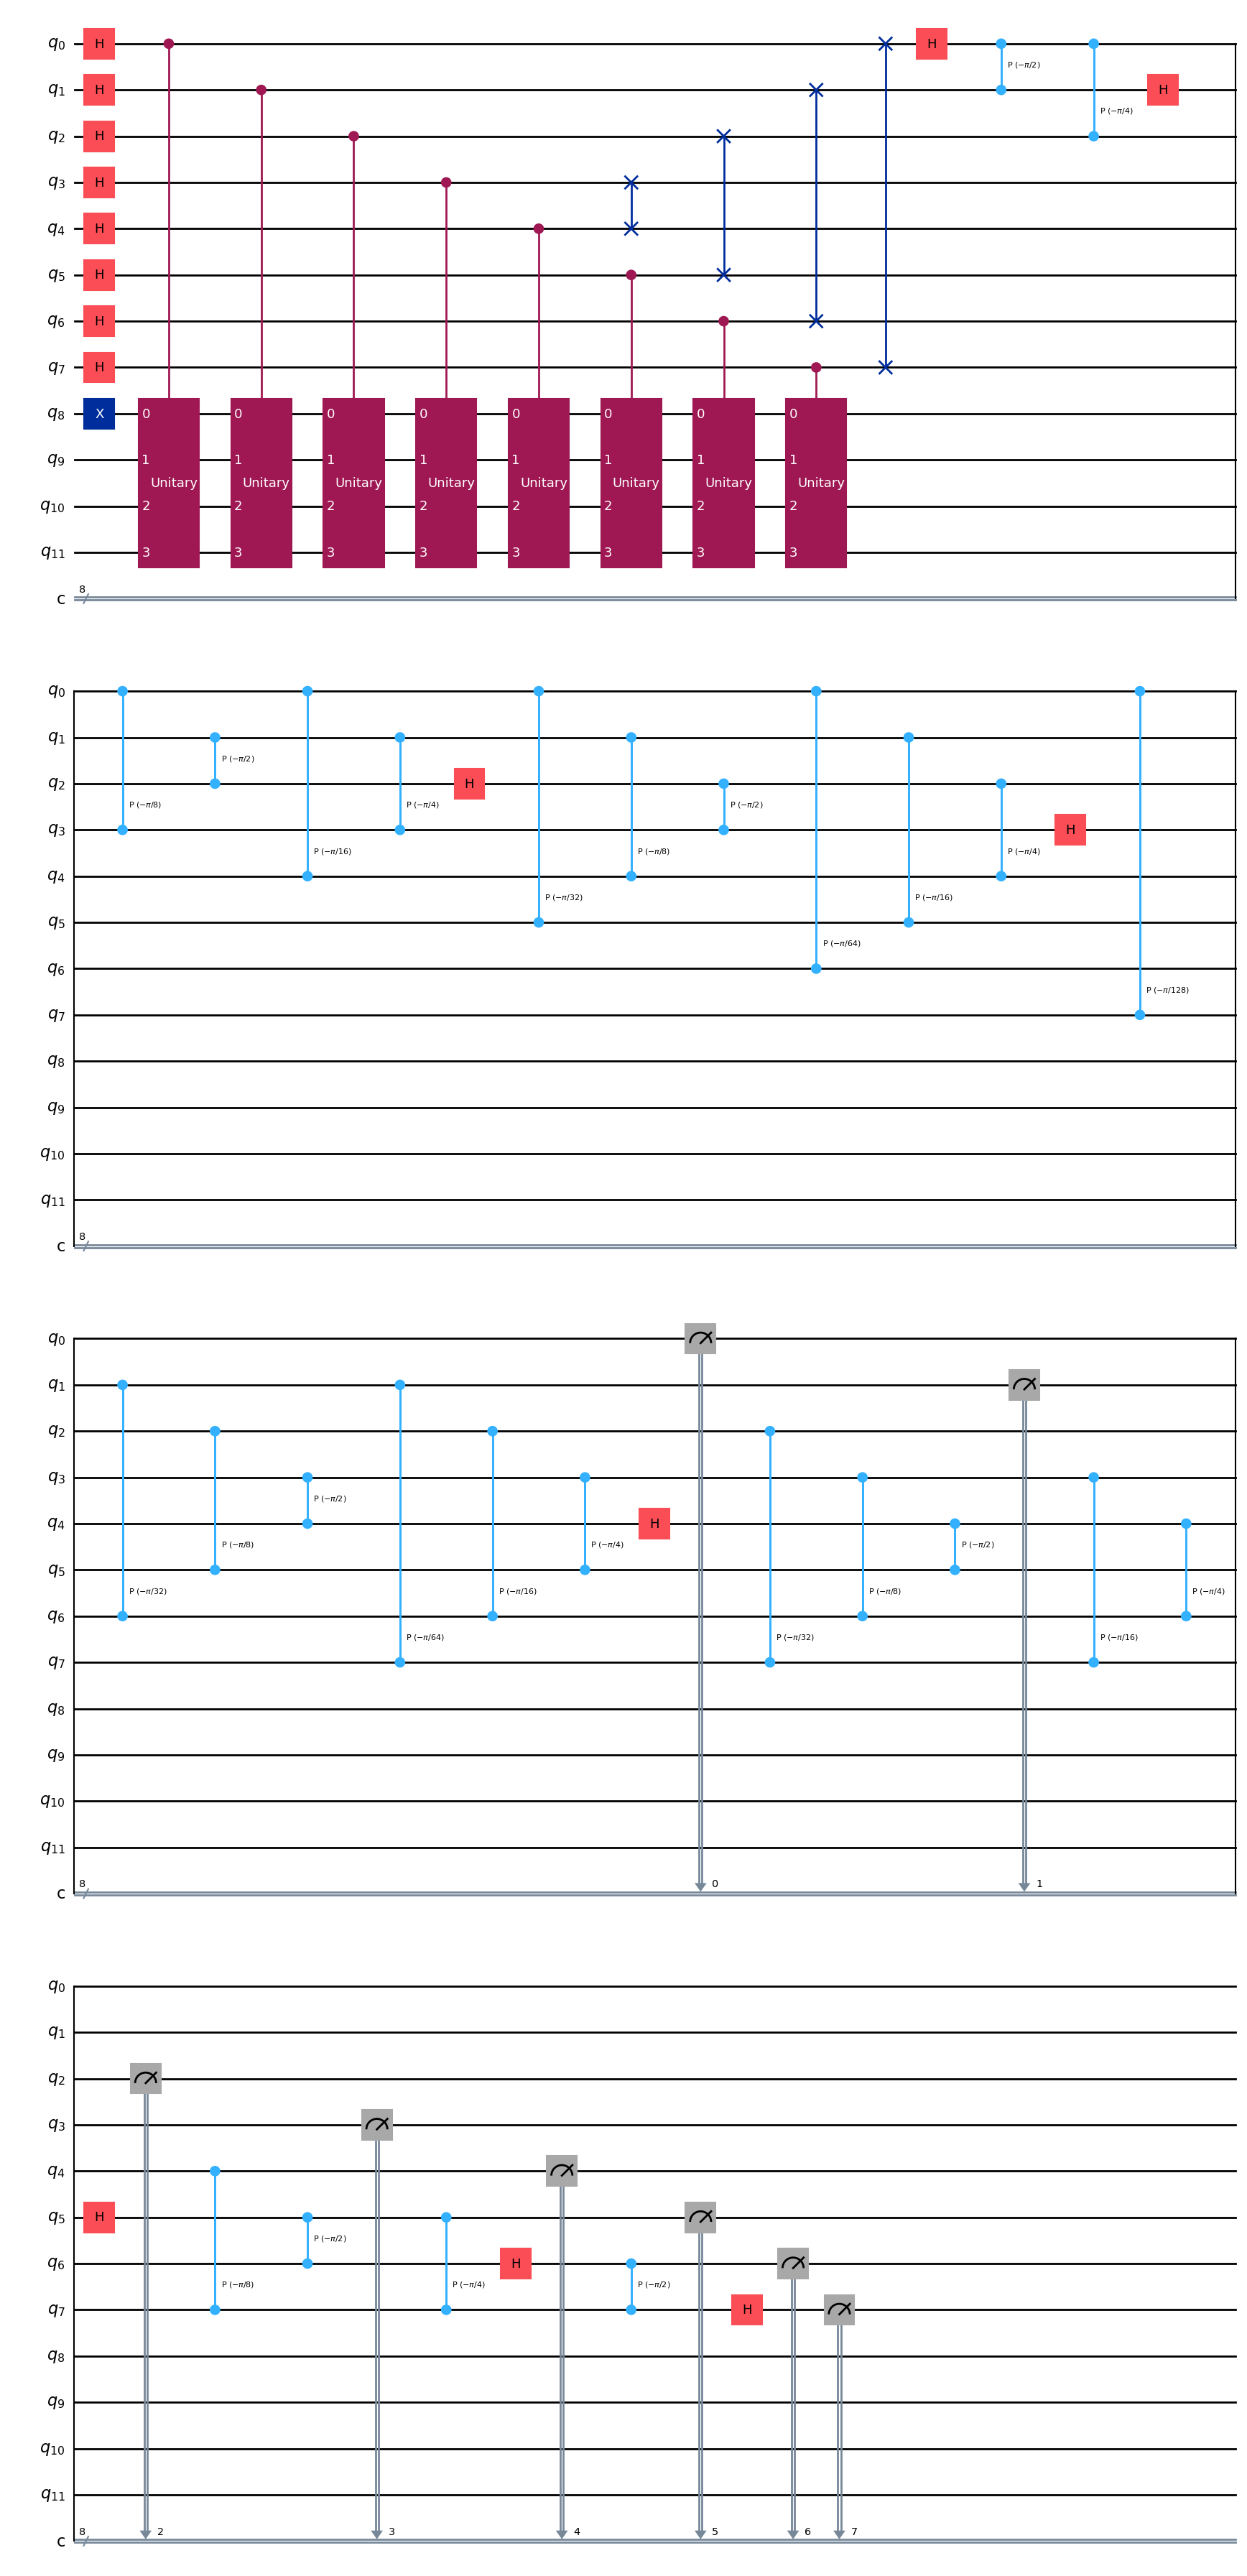

Raw measurement counts (top 10): {'10101010': 59, '01010101': 235, '01000110': 2, '10101001': 10, '00000000': 324, '01010110': 70, '10101011': 236, '01010100': 16, '01011000': 3, '10101100': 15}
Measured s = 0 (binary 00000000)


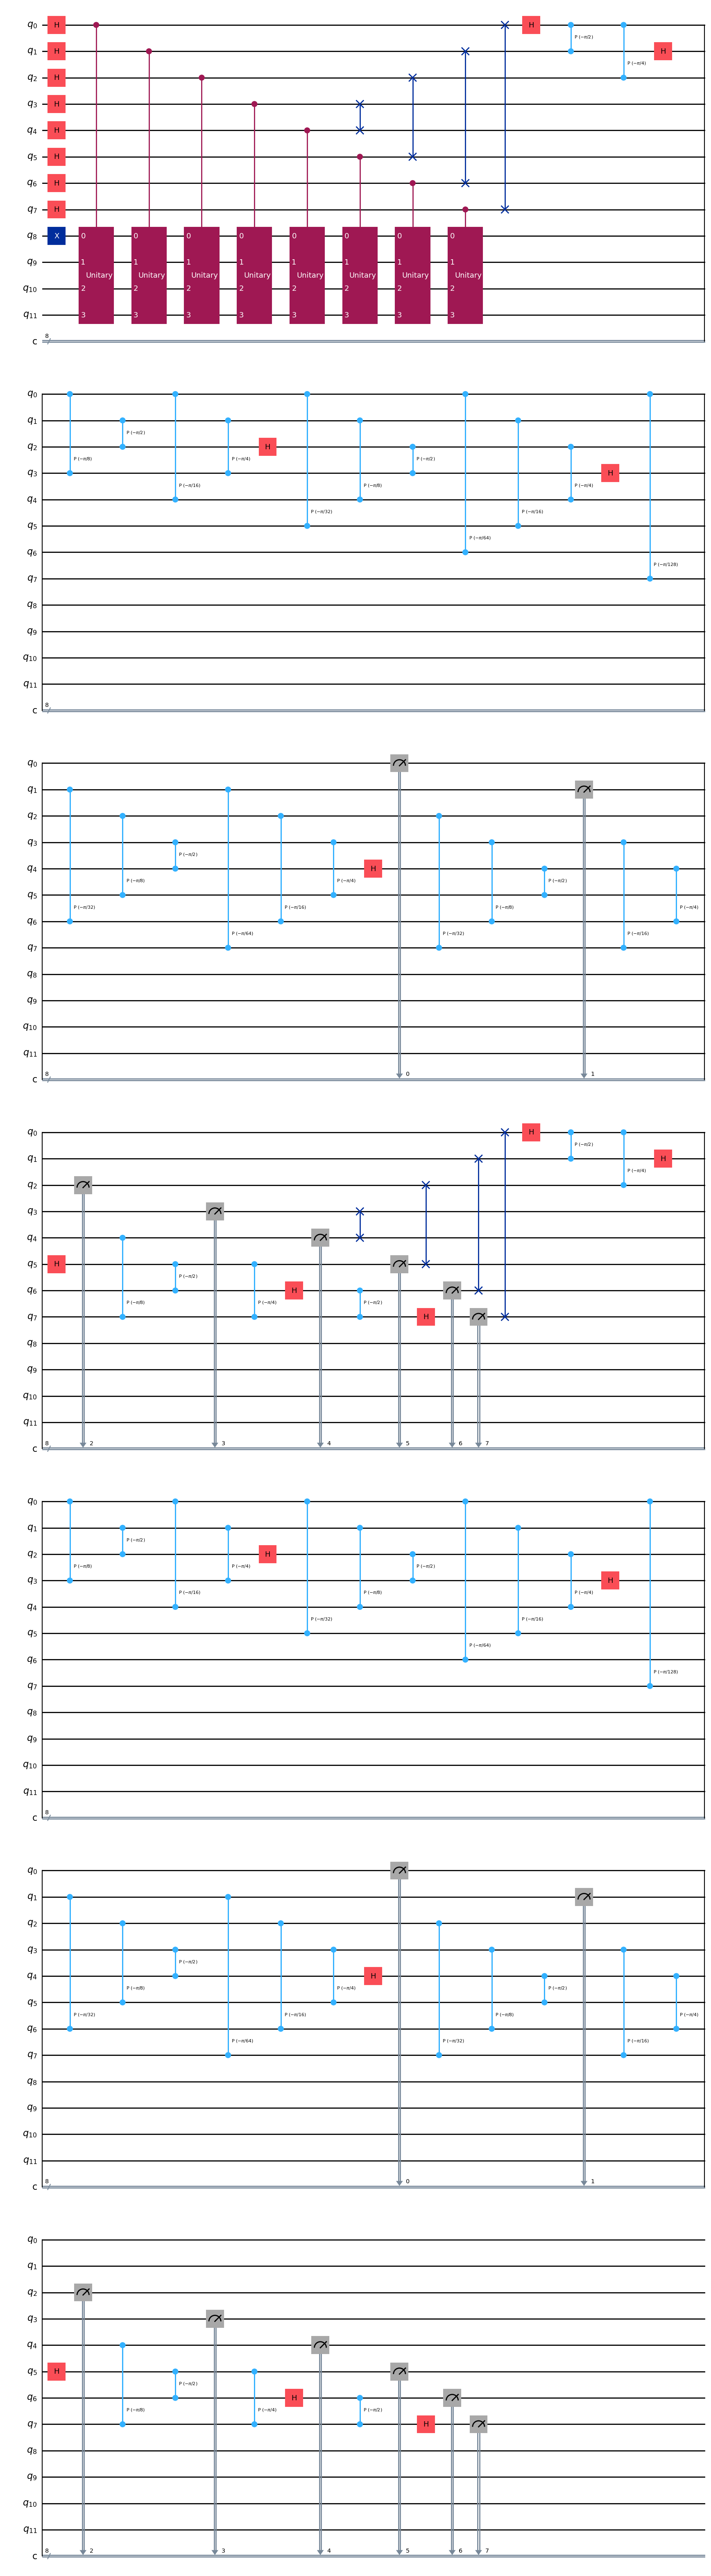

Raw measurement counts (top 10): {'00111001': 2, '11111011': 4, '01000010': 5, '11001100': 7, '11100001': 3, '00110011': 4, '00101101': 5, '10011110': 6, '11101001': 6, '01011001': 4}
Measured s = 126 (binary 01111110)
Found order r = 6 for a = 4
Trivial factors found; retrying...
Attempt 5: got gcd(a, N) = 3 directly (a=6)
Result: (3, 3)


In [11]:
"""
Attempt to factor N using Shor's algorithm (quantum order-finding via QPE + classical post-processing).
Works best for small composite N (e.g., 9). Returns (factor1, factor2) on success or None if failed.
"""
N = 9
print(f"Attempting to factor N = {N} using Shor's algorithm (simulation).")
result = shors_algorithm(N, max_attempts=6, verbose=True)
print("Result:", result)